# Cross Validation and RBF Kernel

## Learning from Data: Homework 8

For this homework, the library _libsvm_ is needed. The easiest way to install this on _Mac OS X_ is using [_Homebrew_](http://brew.sh/) with the following command: `brew install libsvm`.

The following questions from this homework will be answered and its solutions will be explained: questions 7, 8, 9 and 10.

## Polynomial kernel
In the first 2 questions, we need to experiment with 10-fold cross-validation using a polynomial kernel. We will first explain the workings of support vector machines, after which we will look at the use of a polynomial kernel. Afterwards, we see why cross-validation is useful and how it works.

The purpose of support vector machines is to find dichotomies with border margins that are as large as possible.
As we saw in the lectures, we first need the distance between the hyperplane $w^Tx=0$ and the nearest point to that hyperplane, in which $w$ are weights and $x$ are data points. This was found to be $\frac{1}{\|w\|}$.
This is the value that needs to be maximized in order to get a margin as big as possible. This can be restated by saying that we need to minimize the value $\frac{1}{2}w^\intercal w$. This is allowed because minimizing this quantity maximizes the original quantity. <br />
The optimization should also be subject to $|w^\intercal x_n + b| \geq 1$ (in which $b$ is the bias) for $n=1,2,\dots,N$, because the distance from the separating hyperplane to its nearest point should be normalized to be 1. Eventually, we get the following Lagrangian formulation which incorporates both the quantity to minimize and the constraint:
$$
\mathcal{L}(\alpha) = \sum_{n=1}^N \alpha_n - \frac{1}{2} \sum_{n=1}^N \sum_{m=1}^N y_ny_m \alpha_n\alpha_m x_n^\intercal x_m
$$
In which $y_n$ and $y_m$ are target values and $\alpha_n$ and $\alpha_m$ are Lagrange multipliers.
Using quadratic programming, we eventually become $\alpha=\alpha_1, \alpha_2, \dots, \alpha_N$, which maximizes $\frac{1}{2}w^\intercal w$, while taking into account the constraint. When $\alpha_n > 0$, we say that the corresponding data point $x_n$ is a support vector. The hyperplane that separates the points is completely determined by those support vectors and must lie between the support vectors of different target values.

For data which is not linearly separable, a nonlinear transform is needed, in which a transformation (using the function $\phi$) of the data is done from the $\mathcal{X}$ to the $\mathcal{Z}$ space. The resulting data in this $\mathcal{Z}$ is then linearly separable.


In a polynomial kernel, we use a nonlinear transformation function $\phi: \mathcal{X} \rightarrow \mathcal{Z}$ that is a polynomial of a certain order $Q$.
It is possible to do this nonlinear transformation first and then apply quadratic programming using the transformed data to obtain our solution. This can however be infeasible when we have a high-order $\phi$ function, because transforming all the data is computationally expensive. When we look at the Lagrange formulation however, we see that the training data is only used in a dot product of 2 such data points: $x_n^\intercal x_m$. Thus, we actually only need the result of this dot product in the $\mathcal{Z}$ space. The transformed data is not used in any other way. A function that takes 2 data points in the $\mathcal{X}$ space and computes their inner product in the $\mathcal{Z}$ space is called a kernel function. In a polynomial kernel, this function is $K(x,x')=(1+x^\intercal x')^Q$. We can thus replace the inner product in the Lagrange formulation with this kernel function.


There are however cases where the data is slightly non-separable but not so much that a non-linear transformation is needed, or the that is still non-separable after a transformation. As a result, some points violate the margin ($|w^\intercal x_n + b| \geq 1$ is violated). The total violation was found to be $\sum_{n=1}^N \xi_n$. An order of this value (the value $C$) is added to the value that needs to be minimized using quadratic programming in order to allow some errors. The higher $C$, the more errors are allowed in separating the data. Intuitively, we see that increasing $C$ makes the decision surface more smooth and simple. A margin that uses this $C$ is called a soft margin.


For the first 2 exercises, we use cross validation. In the slides, we first saw that using small partition of the training set to validate the learned hypothesis leads to a bad estimate because the points taken out of the training set ($K$ points out of $N$) for validation may not be representative for estimating the out-of-sample error, $E_{out}$. When, we take a large partition however, we get again an accurate validation error ($E_{val}$), but because the model is learned from a small number of data points, we have a bigger chance of getting a bad model for the data. Thus, we need to balance $K$.

The optimal situation however would be to have $K$ both small and large, thus getting a good model and a good estimation of $E_{out}$. To achieve this, we use points one time for validating, and other times for training a model.
We separate the $N$ datapoints into a number of folds, $F$. These number of folds could be as large as $N$ itself, in which $N$ iterations will take place and when only one point is used for validation.
In cross-validation, $K=\frac{N}{F}$, but these K points differ each time as a different fold is used for validation.
The total cross-validation error will then be $E_{cv}=\frac{1}{F}\sum_{n=1}^F e_n$, in which $e_n=E_{val}(g_n^-)$ and $g_n^-$ is the model trained on $N-K$ datapoints.

In all the exercises, we only take data with as target value (digit) 1 or 5 and replace this target values by respectively -1 and 1.
After listing all the possible values on $C$ that need to be used with the support vector machine, we do a number of runs. In each run, we separate the training data randomly into 10 folds. Then, for each value of $C$, we iterate 10 times. Each time take a different fold on which the classifier will be tested and the other 9 folds to train the classifier. This classifier is made using a support vector machine which is given the current value of $C$.

In [14]:
from svmutil import *
import pandas as pd
from sklearn.cross_validation import KFold
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import operator
pd.options.mode.chained_assignment = None
%matplotlib inline

In [2]:
train = pd.read_table("features.train", sep=" +", header=None, engine='python')
train.columns = ["digit", "intensity", "symmetry"]
test = pd.read_table("features.test", sep=" +", header=None, engine='python')
test.columns = ["digit", "intensity", "symmetry"]

In [3]:
train.head()

,digit,intensity,symmetry
0,6,0.341092,-4.528937
1,5,0.444131,-5.496812
2,4,0.231002,-2.886750
3,7,0.200275,-3.534375
4,3,0.291936,-4.352062


In [4]:
filtered = train[(train.digit == 1) | (train.digit == 5)]
filtered.loc[filtered.digit == 1, "digit"] = -1
filtered.loc[filtered.digit == 5, "digit"] = 1
filtered = filtered.reset_index(drop=True)

In [5]:
filtered.head()

,digit,intensity,symmetry
0,1,0.444131,-5.496812
1,-1,0.123043,-0.707875
2,-1,0.113859,-0.931375
3,-1,0.115371,-0.386000
4,-1,0.102281,-0.378812


In [6]:
possible_C = np.array([0.0001, 0.001, 0.01, 0.1, 1])
runs = 100

best_run_C = np.zeros(runs)
C_val_errors = {c: np.zeros(runs) for c in possible_C}

for run in range(runs):
    kf = KFold(len(filtered), n_folds=10, shuffle=True)
    C_errors = np.zeros(len(possible_C))
    for i,C in enumerate(possible_C):
        fold_errors = np.zeros(len(kf))
        for j, index_pair in enumerate(kf):
            train_index, val_index = index_pair
            
            train_fold = filtered.ix[train_index]
            train_x = train_fold[["intensity", "symmetry"]].values.tolist()
            train_y = train_fold["digit"].values.tolist()
            
            val_fold = filtered.ix[val_index]
            val_x = val_fold[["intensity", "symmetry"]].values.tolist()
            val_y = val_fold["digit"].values.tolist()
            
            m = svm_train(train_y, train_x, '-q -t 1 -d 2 -c {} -r 1 -g 1'.format(C))
            p_label, p_acc, p_val = svm_predict(val_y, val_x, m, "-q")
            fold_errors[j] = (100-p_acc[0])/100.
            
        mean_fold_error = np.mean(fold_errors)
        C_val_errors[C][run] = mean_fold_error
        C_errors[i] = mean_fold_error
    best_run_C[run] = possible_C[np.argmin(C_errors)]

### Question 7

Consider the 1 versus 5 classifier with Q = 2. We use $E_{cv}$ to select $C \in \{0.0001, 0.001, 0.01, 0.1, 1\}$. If there is a tie in $E_{cv}$ , select the smaller C . Within the 100 random runs, which of the following statements is correct?


After training, the classifier is tested and the errors on the test fold are saved. Afterwards, we average all errors for specific $C$ values for each fold over all the runs. We then calculate which $C$ yielded the lowest error rate in each run. By then calculating which $C$ was the most number of times selected as the one with the lowest error rate, we know which $C$ value is the best.

In [17]:
ctr = Counter(best_run_C)
best_c = ctr.most_common(1)[0][0]
print("Best C: ", best_c)

Best C:  0.001


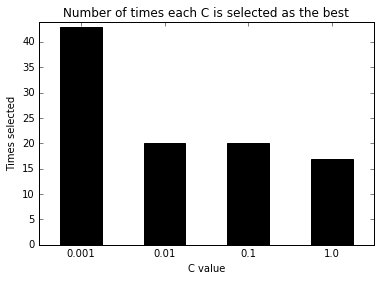

In [40]:
X = np.arange(len(ctr))
sorted_ctr = sorted(ctr.items(), key=operator.itemgetter(0))
keys = [t[0] for t in sorted_ctr]
values = [t[1] for t in sorted_ctr]
plt.bar(X, values, align='center', width=0.5, color="black")
plt.xticks(X, keys)
ymax = max(values) + 1
plt.ylim(0, ymax)
plt.title("Number of times each C is selected as the best")
plt.xlabel("C value")
plt.ylabel("Times selected")
plt.show()

The lowest cross validation error is achieved when $C=0.001$. As a result, our answer to this question is B.

### Question 8

Again, consider the 1 versus 5 classifier with $Q = 2$. For the winning selection
in the previous problem, the average value of $E_{cv}$ over the 100 runs is closest to...

In this question, we need to report the error of the results using the best C value. As already saved this in order to calculate which C yielded the best results, reporting this value is easy.

In [20]:
print("Cross validation error when using C=", best_c, ": ", np.mean(C_val_errors[best_c]))

Cross validation error when using C= 0.001 :  0.00477266046056


The achieved cross validation error is closest to $0.005$, which means that our answer is C.

## RBF kernel
For the next questions, a radial basis function (RBF) kernel is used. This kernel is of the following form:
$$
K(x_n,x_m)=e^{-\gamma\|x_n-x_m\|^2}
$$
Here, $x_n$ and $x_m$ are again data points. Besides the different kernel, this approach is the same as with the support vector machine using the polynomial kernel which was explained earlier. $\gamma$ is a parameter passed to the algorithm and influences the variance of the obtained function. Each data point has an influence on the hypothesis based on its radial distance $\|x-x_n\|$. Intuitively, this means that nearby points have more influence than data points that are farther away. A small $\gamma$ means that a single data point has a lot of influence and leads to low bias and high variance models, while a high $\gamma$ leads to less influence and will give you a higher bias and lower variance.

Notice that the corresponding non-linear transform ($\phi$) of the kernel generates infinite-dimensional data points. As such, first computing the transform and then applying the inner product of 2 points would not be possible.

For the following questions, we always use $\gamma=1$ and we use the soft margin approach which was explained earlier. The experiments then involve trying different values for C.

In [21]:
filtered_test = test[(test.digit == 1) | (test.digit == 5)]
filtered_test["digit"].replace(1,float(-1),inplace=True)
filtered_test["digit"].replace(5,float(1),inplace=True)
filtered_test = filtered_test.reset_index(drop=True)

In [22]:
possible_C = [0.01, 1, 100, 10**4, 10**6]
E_ins = np.zeros(len(possible_C))
E_outs = np.zeros(len(possible_C))

for i,C in enumerate(possible_C):
    train_x = filtered[["intensity", "symmetry"]].values.tolist()
    train_y = filtered["digit"].values.tolist()
    
    test_x = filtered_test[["intensity", "symmetry"]].values.tolist()
    test_y = filtered_test["digit"].values.tolist()
    
    m = svm_train(train_y, train_x, '-q -t 2 -d 2 -c {} -g 1'.format(C))
    train_label, train_acc, train_val = svm_predict(train_y, train_x, m, "-q")
    test_label, test_acc, test_val = svm_predict(test_y, test_x, m, "-q")
    
    E_ins[i] = (100-train_acc[0])/100.
    E_outs[i] = (100-test_acc[0])/100.

### Question 9

Which of the following values of C results in the lowest $E_{in}$?

For this question, we had to report the C value which yielded the lowest in-sample error. To do this, we train for each value of C the SVM with that particular C on all data (of digits 1 and 5) and use this classifier on the training and test data (of digits 1 and 5). The errors on the training data and test data are then saved to separate lists.
We then report the value of C with the lowest corresponding error in the list of in-sample errors.

In [25]:
possible_C[np.argmin(E_ins)]

1000000

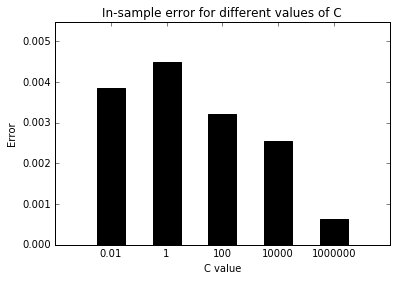

In [37]:
X = np.arange(len(E_ins))
plt.bar(X, E_ins, align='center', width=0.5, color="black")
plt.xticks(X, possible_C)
ymax = max(E_ins) + 0.001
plt.ylim(0, ymax)
plt.title("In-sample error for different values of C")
plt.xlabel("C value")
plt.ylabel("Error")
plt.show()

We see that we get the lowest in-sample error when $C=1000000$. This means that the answer to this question is E.

### Question 10

Which of the following values of C results in the lowest $E_{out}$?

Here, we need to report the C value that gave us the lowest out-of-sample error. As already mentioned, the errors on the test data were already saved to a list. Thus, we now need to report the value of C with the lowest corresponding error in this list of out-of-sample errors

In [30]:
possible_C[np.argmin(E_outs)]

100

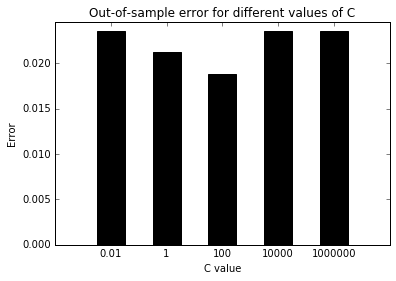

In [39]:
X = np.arange(len(E_outs))
plt.bar(X, E_outs, align='center', width=0.5, color="black")
plt.xticks(X, possible_C)
ymax = max(E_outs) + 0.001
plt.ylim(0, ymax)
plt.title("Out-of-sample error for different values of C")
plt.xlabel("C value")
plt.ylabel("Error")
plt.show()

The lowest out-of-sample error is achieved when $C=100$. This is equal to the value of answer C.